In [1]:
gpu_info = !nvidia-smi
gpu_info = gpu_info[:10]
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Oct  7 20:01:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns

In [48]:
import sys
import torch
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm_notebook as tq

from torch.autograd import Variable
from torchvision.transforms import transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

In [5]:
base_path = "/content/drive/My Drive/UC Davis Synthetic Data/Prashanth's/Autoencoder/Autoencoder/"
sys.path.append(base_path)

In [6]:
from src.data_utils import LoadDataset, SavePath
from src.config import TrainConfig

In [7]:
args = TrainConfig( base_path,              # project directory path
                    n_epochs = 200,         # number of epochs to train (default: 100)
                    batch_size = 128,       # input batch size for training (default: 128)
                    lr = 0.0002,            # learning rate (default: 0.0001)
                    dim_h = 128,            # hidden dimension (default: 128)')
                    n_z = 8,                # hidden dimension of z (default: 8)
                    LAMBDA = 10,            # regularization coef term (default: 10)
                    sigma = 1,              # variance of hidden dimension (default: 1)
                    n_channel = 1,          # input channels (default: 1)
                    img_size = 28 )         # image size

In [22]:
load_linear = SavePath(args, checkpoint_path="/content/drive/My Drive/UC Davis Synthetic Data/Prashanth's/Autoencoder/Autoencoder/outs/Tue-Sep-29-22-37-45-2020/")
load_conv = SavePath(args, checkpoint_path="/content/drive/My Drive/UC Davis Synthetic Data/Prashanth's/Autoencoder/Autoencoder/outs/Fri-Sep-18-19-57-30-2020/")

/content/drive/My Drive/UC Davis Synthetic Data/Prashanth's/Autoencoder/Autoencoder/outs/Tue-Sep-29-22-37-45-2020/
/content/drive/My Drive/UC Davis Synthetic Data/Prashanth's/Autoencoder/Autoencoder/outs/Fri-Sep-18-19-57-30-2020/


In [9]:
cdl = LoadDataset(args, data='mnist')
train_loader = cdl.get_data_loader(train=True)
test_loader = cdl.get_data_loader(train=False)

In [14]:
class LinearEncoder(nn.Module):

    def __init__(self, args):
        super(LinearEncoder, self).__init__()
        
        self.n_z = args.n_z
        self.dim_h = args.dim_h
        self.dim_input = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Linear(self.dim_input, self.dim_h * 16),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 16, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 2),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 2, self.dim_h),
            nn.ReLU(True),
            nn.Linear(self.dim_h, self.n_z)
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [15]:
class LinearDecoder(nn.Module):

    def __init__(self, args):
        super(LinearDecoder, self).__init__()

        self.n_z = args.n_z
        self.dim_h = args.dim_h
        self.dim_output = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h),
            nn.ReLU(True),
            nn.Linear(self.dim_h, self.dim_h * 2),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 2, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 16),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 16, self.dim_output),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [16]:
from src.model import Encoder as ConvEncoder
from src.model import Decoder as ConvDecoder

In [66]:
def imshow(img):
    plt.figure(figsize=(16,16))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [17]:
conv_encoder, conv_decoder = ConvEncoder(args), ConvDecoder(args)
linear_encoder, linear_decoder = LinearEncoder(args), LinearDecoder(args)

In [23]:
_, _, conv_model_path =  load_conv.get_save_paths()
_, _, linear_model_path = load_linear.get_save_paths()

conv_checkpoint = 300
linear_checkpoint = 400

In [24]:
conv_encoder.load_state_dict(torch.load(conv_model_path + "/encoder_{}.pth".format(conv_checkpoint)))
conv_decoder.load_state_dict(torch.load(conv_model_path + "/decoder_{}.pth".format(conv_checkpoint)))
linear_encoder.load_state_dict(torch.load(linear_model_path + "/encoder_{}.pth".format(linear_checkpoint)))
linear_decoder.load_state_dict(torch.load(linear_model_path + "/decoder_{}.pth".format(linear_checkpoint)))

<All keys matched successfully>

In [68]:
test_iter = iter(test_loader)
test_data, test_labels = next(test_iter)
test_labels = test_labels.numpy()

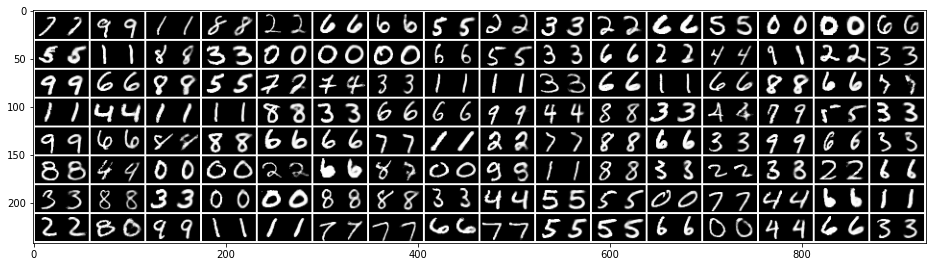

In [81]:
# linear to linear
test_data_flattened = test_data.reshape([test_data.size()[0], 1, args.img_size**2])
z_linear = linear_encoder(test_data_flattened).squeeze()
reconst_linear_to_linear = linear_decoder(z_linear).view(128, 1, 28, 28)
image_linear_to_linear = torch.cat((test_data_flattened.view(128, 1, 28, 28), reconst_linear_to_linear.data), axis=3)
imshow(make_grid(image_linear_to_linear, nrow=16, pad_value=1))

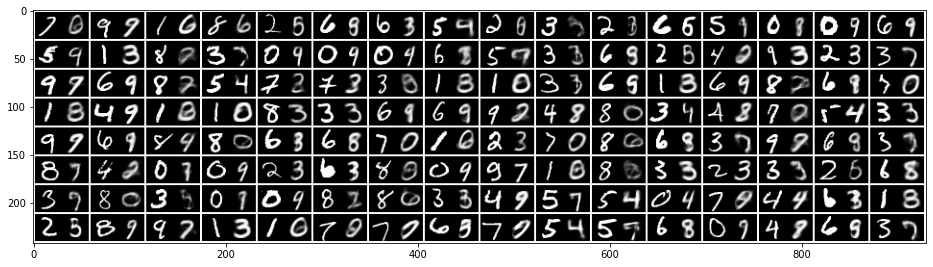

In [80]:
# Linear to conv
test_data_flattened = test_data.reshape([test_data.size()[0], 1, args.img_size**2])
z_linear = linear_encoder(test_data_flattened).squeeze()
reconst_linear_conv = conv_decoder(z_linear).view(128, 1, 28, 28)
image_linear_to_conv = torch.cat((test_data_flattened.view(128, 1, 28, 28), reconst_linear_conv.data), axis=3)
imshow(make_grid(image_linear_to_conv, nrow=16, pad_value=1))

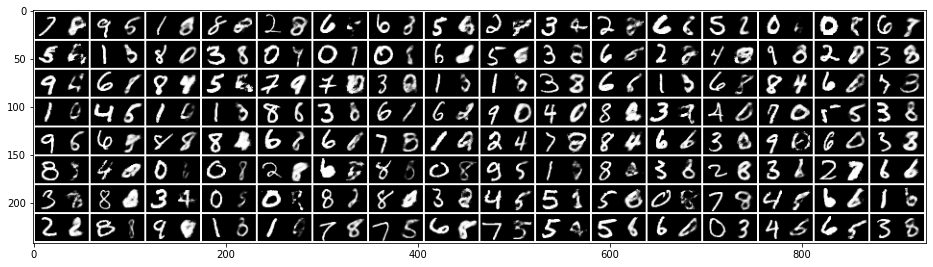

In [79]:
# conv to linear
z_conv = conv_encoder(test_data).squeeze()
reconst_conv_to_linear = linear_decoder(z_conv).view(128, 1, 28, 28)
image_conv_to_linear = torch.cat((test_data.view(128, 1, 28, 28), reconst_conv_to_linear.data), axis=3)
imshow(make_grid(image_conv_to_linear, nrow=16, pad_value=1))

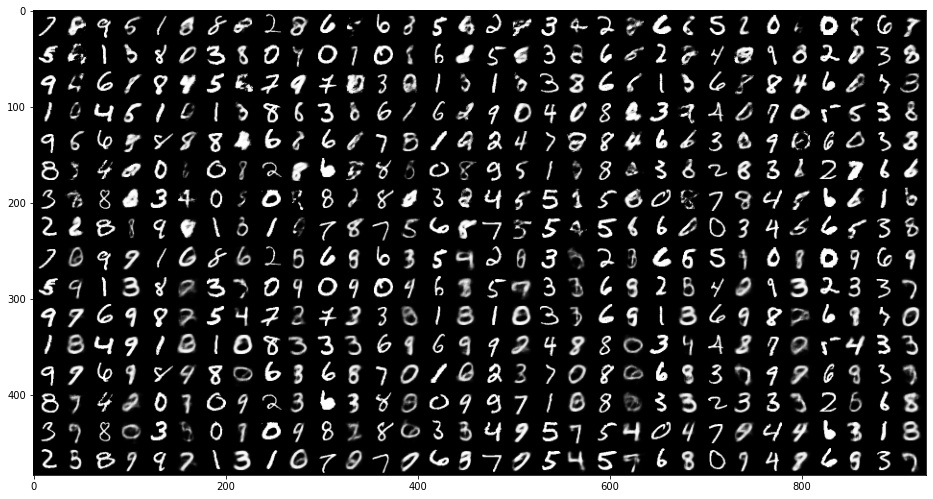

In [96]:
imshow(torch.cat((make_grid(image_conv_to_linear, nrow=16), make_grid(image_linear_to_conv, nrow=16)), axis = 1))

In [ ]:
test_iter = iter(test_loader)
test_data, test_labels = next(test_iter)
test_data = test_data.reshape([test_data.size()[0], 1, args.img_size**2])
test_labels = test_labels.numpy()
z_test = encoder(test_data)
z_test = z_test.squeeze().detach().cpu().numpy()
z_test.shape

In [ ]:
train_iter = iter(train_loader)
train_data, train_labels = next(train_iter)
train_data = train_data.to(device='cuda')
train_data = train_data.reshape([train_data.size()[0], 1, args.img_size**2])

In [ ]:
train_labels = train_labels.numpy()
z_train = encoder(train_data)
z_train = z_train.squeeze().detach().cpu().numpy()
z_train.shape

(128, 8)

In [89]:
tsne = TSNE()
pca = PCA()

In [86]:
# z_linear_tsne = tsne.fit_transform(z_linear)
# z_test_tsne = tsne.fit_transform(z_test)
z_linear_pca = pca.fit_transform(z_linear.detach().numpy())
z_conv_pca = pca.fit_transform(z_conv.detach().numpy())

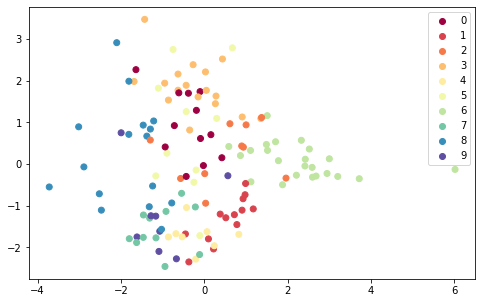

In [87]:
plt.figure(figsize=(8,5))
scatter  = plt.scatter(z_linear_pca[:,0], z_linear_pca[:,1], c=test_labels, cmap='Spectral')
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(test_labels)))
plt.show()

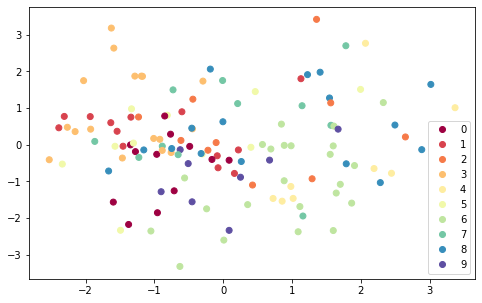

In [88]:
plt.figure(figsize=(8,5))
scatter  = plt.scatter(z_conv_pca[:,0], z_conv_pca[:,1], c=test_labels, cmap='Spectral')
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(test_labels)))
plt.show()

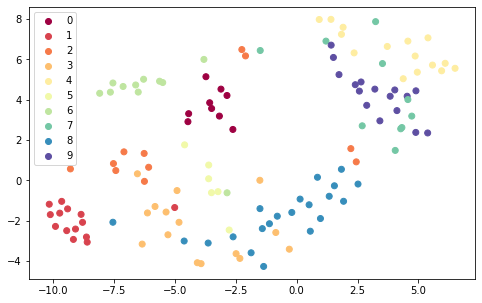

In [ ]:
plt.figure(figsize=(8,5))
scatter  = plt.scatter(z_train_tsne[:,0], z_train_tsne[:,1], c=train_labels, cmap='Spectral')
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(train_labels)))
plt.show()

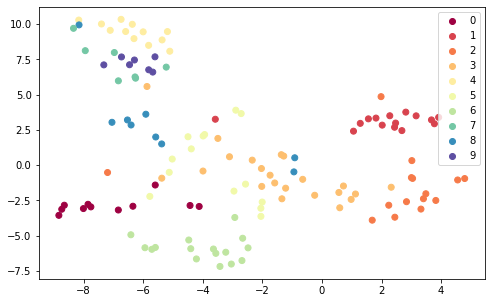

In [ ]:
plt.figure(figsize=(8,5))
scatter  = plt.scatter(z_test_tsne[:,0], z_test_tsne[:,1], c=test_labels, cmap='Spectral')
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(test_labels)))
plt.show()

(128, 8)

In [ ]:
z_l[0]

array([-2.6060193 ,  0.24894208], dtype=float32)

In [ ]:
print('[%s]' % ', '.join(map(str, np.mean(disc_loss, axis=0))))

[0.5, 0.5]


In [ ]:
class Encoder(nn.Module):

    def __init__(self, args):
        super(Encoder, self).__init__()
        
        self.n_z = args.n_z
        self.channels = args.n_channel
        self.dim_input = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Conv1d(self.channels, self.channels * 512, kernel_size=5, stride=3),
            nn.LeakyReLU(0.1, True),
            nn.Conv1d(self.channels * 512, self.channels * 256, kernel_size=4, stride=3),
            nn.LeakyReLU(0.1, True),
            nn.Conv1d(self.channels * 256, self.channels * 128, kernel_size=4, stride=3),
            nn.LeakyReLU(0.1, True),
            nn.Conv1d(self.channels * 128, self.channels, kernel_size=4, stride=2),
            nn.LeakyReLU(0.1, True),
            nn.Linear(13, self.n_z)
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [ ]:
class Decoder(nn.Module):

    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_z = args.n_z
        self.channels = args.n_channel
        self.dim_output = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Linear(self.n_z, 196),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose1d(self.channels, self.channels * 512, kernel_size=6, stride=2, padding=2),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose1d(self.channels*512, self.channels * 256, kernel_size=6, stride=1, padding=2),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose1d(self.channels * 256, self.channels * 1, kernel_size=4, stride=2, padding=2),
            # nn.LeakyReLU(0.1, True),
            # nn.ConvTranspose1d(self.channels * 256, self.channels * 128, kernel_size=4, stride=3),
            # nn.LeakyReLU(0.1, True),
            # nn.ConvTranspose1d(self.channels * 128, self.channels * 1, kernel_size=4, stride=3),
            # nn.LeakyReLU(0.1, True),
            # nn.ConvTranspose1d(self.channels * 32, self.channels, kernel_size=4, stride=2),
            # nn.Linear(715, self.dim_output),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.main(x)
        return x